In [1]:
%matplotlib inline
from matplotlib import style
# Import this for mpl_dates.DateFormatter()
from matplotlib import dates as mpl_dates
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import calendar
from scipy import stats


In [3]:
import datetime as dt
import datetime
from flask import jsonify

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

#?? what is the func and inspect for
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine(f"sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)

In [7]:
# dir(inspector)

In [8]:
tables = inspector.get_table_names()
tables

['measurement', 'station']

In [9]:
# help(inspector.get_columns)

In [10]:
for table in tables:
    print("\n")
    print('-' * 12)
    print(f"table '{table}' has the following columns:")
    print('-' * 12)
    for column in inspector.get_columns(table):
        print(f"name: {column['name']}   column type: {column['type']}, nullable:{column['nullable']}")
        



------------
table 'measurement' has the following columns:
------------
name: id   column type: INTEGER, nullable:False
name: station   column type: TEXT, nullable:True
name: date   column type: TEXT, nullable:True
name: prcp   column type: FLOAT, nullable:True
name: tobs   column type: FLOAT, nullable:True


------------
table 'station' has the following columns:
------------
name: id   column type: INTEGER, nullable:False
name: station   column type: TEXT, nullable:True
name: name   column type: TEXT, nullable:True
name: latitude   column type: FLOAT, nullable:True
name: longitude   column type: FLOAT, nullable:True
name: elevation   column type: FLOAT, nullable:True


In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [12]:
#--Get table names out
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
#--Create classes
Measurement = Base.classes['measurement']
Station = Base.classes['station']

In [14]:
# dir(Measurement)
# dir(Station)

In [15]:
# help(Measurement)

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

** Using date time functions

In [17]:
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()


** Note for study **
Functions to use with NaN : - 
.isna() : check for NaN, 
.fillna() : dosomthing with missisng value, 
.dropna() : drop null value

In [18]:
#--Loaded the query results into Pandas DataFrame
clean_prcp = pd.DataFrame(results)
clean_prcp['date'] = pd.to_datetime(clean_prcp['date'])

#--Clean data by replacing 0 into the null value
clean_prcp = clean_prcp.fillna(0)

#--Set indext to column['date']
clean_prcp = clean_prcp.set_index('date')


#--Sort dataframe by 'date'
clean_prcp.sort_values(by='date', ascending = False)
clean_prcp

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,0.00
2017-08-21,0.56


# Precipitation Bar Chart

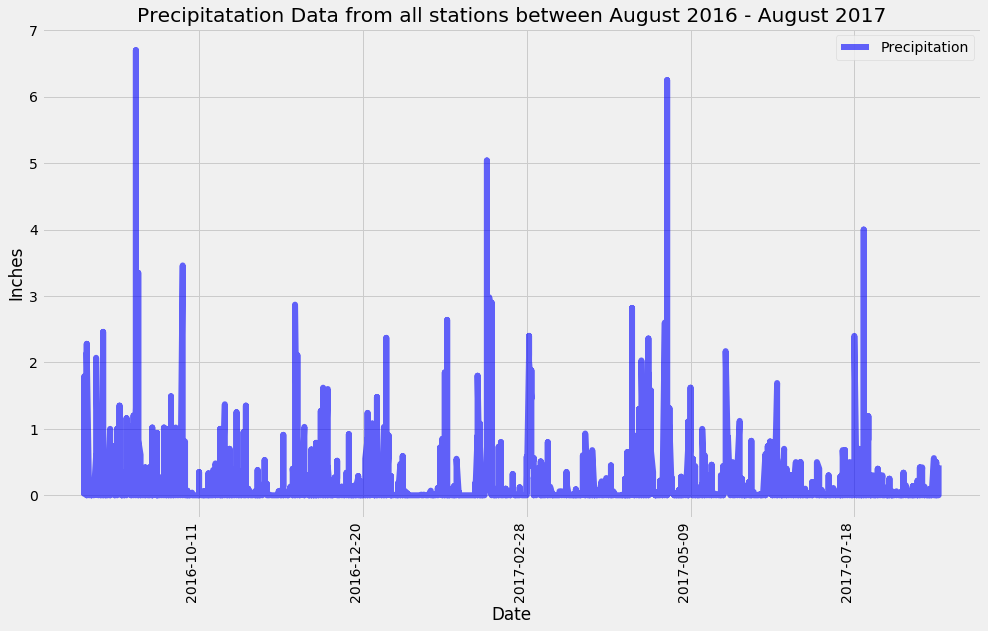

In [19]:
#--assigned x and y axis value
prcp_date = clean_prcp.index
prcp_data = clean_prcp['prcp']

#--template for date to show on x-axis
date_format = DateFormatter("%Y-%m-%d")
ax = clean_prcp.plot(color="blue",alpha=0.6,figsize=(15,10), rot=90, linewidth=6)
ax.xaxis.set_major_formatter(date_format)
# Ensure a major tick using (interval=10 weeks)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))

plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(['Precipitation'], loc = "upper right")
plt.title('Precipitatation Data from all stations between August 2016 - August 2017')
plt.show()

# Precipitations Statistic

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
clean_prcp.describe()

,prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Station Analysis

In [21]:
# Design a query to show how many stations are available in this dataset?
stations_results = session.query(Station.id).count()
stations_results

9

### Find the most active stations 

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active = session.query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station)\
                .order_by(func.count(Measurement.station).desc())

most_active.first()

('USC00519281', 2772)

In [23]:
# List the stations and the counts in descending order.
most_active_df = pd.DataFrame(data=most_active, columns=['Station','Count'])
most_active_df.head()

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [24]:
most_active_station = most_active_df['Station'][0]
most_active_station

'USC00519281'

### Station USC00519281 has the highest number of observations

In [25]:
# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
prev_year

datetime.date(2016, 8, 23)

In [26]:
# Perform a query to retrieve the data and precipitation scores
tobs_results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= prev_year)\
                .filter(Measurement.station == most_active_station).all()
# Data retrieved as a list
tobs_results

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [27]:
#--Loaded the query results into Pandas DataFrame
tobs_12mo = pd.DataFrame(tobs_results)
tobs_12mo = tobs_12mo.set_index('date')
tobs_12mo

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


# Histrogrm of The Observing Temperature of Most Active Station

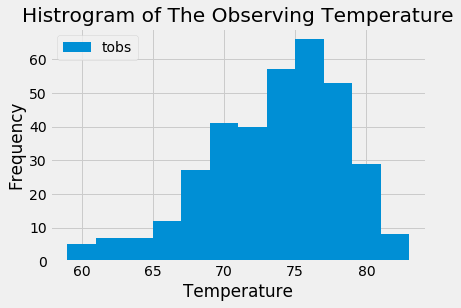

In [28]:
plt.hist(tobs_12mo['tobs'],bins=12)
plt.title('Histrogram of The Observing Temperature')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(['tobs'], loc="upper left")

# Bonus

# 1) Temperature Analysis I (For Hawaii Weather)

In [29]:
# idea base from: https://riptutorial.com/sqlalchemy/example/6614/converting-a-query-result-to-dict
def object_as_dict(obj):
    """
    This function takes in a Class instance (row ) from an ORM query and converts it to a dictionary
    """
    obj_count = 1
    try:
        obj_count = len(obj)
    except:
        pass
    if  obj_count == 1:
        base_dict = {c.key: getattr(obj, c.key)
            for c in inspect(obj).mapper.column_attrs}
        return base_dict
    else:
        cur_obj = obj[0]
        base_dict = {c.key: getattr(cur_obj, c.key) for c in inspect(cur_obj).mapper.column_attrs}
        for i in range(1, obj_count):
            cur_obj = obj[i]
            cur_dict = {c.key: getattr(cur_obj, c.key) for c in inspect(cur_obj).mapper.column_attrs}
            base_dict = {**base_dict, **cur_dict} 
        return base_dict

In [30]:
def query_to_list_of_dicts(cur_query):
    """
    From a query object return a list of dictionaries
    """
    return [object_as_dict(row) for row in cur_query]

In [31]:
measurment = query_to_list_of_dicts(session.query(Measurement))
measurment_df = pd.DataFrame(measurment)
measurment_df.dtypes

id           int64
station     object
date        object
prcp       float64
tobs       float64
dtype: object

In [32]:
measurment_df.date = pd.to_datetime(measurment_df.date, infer_datetime_format = True)

In [33]:
measurment_df.dtypes
measurment_df.set_index(['date'], inplace = True)
measurment_df

,id,station,prcp,tobs
date,,,,
2010-01-01,1,USC00519397,0.08,65.0
2010-01-02,2,USC00519397,0.00,63.0
2010-01-03,3,USC00519397,0.00,74.0
2010-01-04,4,USC00519397,0.00,76.0
2010-01-06,5,USC00519397,NaN,73.0
...,...,...,...,...
2017-08-19,19546,USC00516128,0.09,71.0
2017-08-20,19547,USC00516128,NaN,78.0
2017-08-21,19548,USC00516128,0.56,76.0


In [34]:
june_avg_temp = measurment_df.loc[measurment_df.index.month == 6]
june_avg_temp.mean()

id      9752.647647
prcp       0.136360
tobs      74.944118
dtype: float64

In [35]:
dec_avg_temp = measurment_df.loc[measurment_df.index.month == 12]
dec_avg_temp.mean()

id      9816.710613
prcp       0.216819
tobs      71.041529
dtype: float64

In [36]:
stats.ttest_ind(june_avg_temp.tobs,dec_avg_temp.tobs)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

# Conclusion for analysis for Hawaii Weather

### Hawaii has mild weather all year base on the ttest that we used to compare average weather from all stations in June and December since the pvalue is less than 0.5

# 2) Temperature Analysis II

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-03-15', '2017-03-31'))

[(65.0, 73.48543689320388, 80.0)]


### My Vacation date between '2017-03-15' and '2017-03-30'

In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# My Vacation date between '2017-02-28' and '2017-03-05'
print(calc_temps('2017-03-15', '2017-03-31'))

[(65.0, 73.48543689320388, 80.0)]


Text(0, 0.5, 'Temperature')

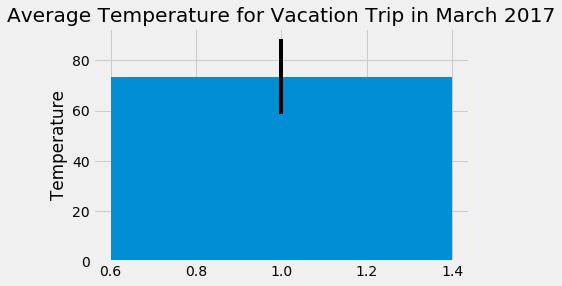

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_bar = list(np.ravel(calc_temps('2017-03-15', '2017-03-31')))

plt.bar(1,temp_bar[1],yerr=temp_bar[2]-temp_bar[0])
plt.title('Average Temperature for Vacation Trip in March 2017')
plt.ylabel("Temperature")


In [40]:
total_rainfall = session.query(Measurement.station, 
                               Station.name,\
                               func.sum(Measurement.prcp),\
                               Station.latitude,\
                               Station.longitude,\
                               Station.elevation)\
                               .filter(Measurement.date >= '2016-08-23')\
                               .filter(Measurement.station == most_active_station)\
                               .group_by(Measurement.station)\
                               .order_by(func.sum(Measurement.prcp).desc()).all()
total_rainfall

[('USC00519281',
  'WAIKIKI 717.2, HI US',
  630.2699999999962,
  21.2716,
  -157.8168,
  3.0)]

In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_rainfall = session.query(Measurement.station, 
                               Station.name,\
                               func.sum(Measurement.prcp),\
                               Station.latitude,\
                               Station.longitude,\
                               Station.elevation)\
                               .filter(Measurement.date >= '2016-08-23')\
                               .filter(Measurement.station == most_active_station)\
                               .group_by(Measurement.station)\
                               .order_by(func.sum(Measurement.prcp).desc()).all()
tt_rain_dict = {}
###
#Using when desparate
###
for r in total_rainfall:
    #using [][] because of the result of total_rainfall came back as [('...')]
    tt_rain_dict["station"] = total_rainfall[0][0]
    tt_rain_dict["s_name"] = total_rainfall[0][1]
    tt_rain_dict["sum_prcp"] = total_rainfall[0][2]
    tt_rain_dict["lat"] = total_rainfall[0][3]
    tt_rain_dict["lon"] = total_rainfall[0][4]
    tt_rain_dict["ele"] = total_rainfall[0][5]
    
tt_rain_dict

{'station': 'USC00519281',
 's_name': 'WAIKIKI 717.2, HI US',
 'sum_prcp': 630.2699999999962,
 'lat': 21.2716,
 'lon': -157.8168,
 'ele': 3.0}

In [58]:
conn = engine.connect()
rainfall_read_sql = pd.read_sql('select m.station, s.name,\
                                sum(m.prcp) as sum_prcp, \
                                s.latitude, s.longitude, s.elevation\
                                from measurement m \
                                join station s \
                                on m.station = s.station \
                                where m.date >= "2017-08-23"\
                                group by m.station\
                                order by sum_prcp DESC', conn)

print(rainfall_read_sql.shape)
rainfall_read_sql




(4, 6)


,station,name,sum_prcp,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.45,21.33310,-157.80250,152.4
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.08,21.33556,-157.71139,19.5
2,USC00519397,"WAIKIKI 717.2, HI US",0.00,21.27160,-157.81680,3.0
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.00,21.52130,-157.83740,7.0


# Create a query that will calculate the daily normals 

In [44]:
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [45]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []

vac_dates = pd.date_range('2017-03-15','2017-03-31',freq='D')
vac_dates_for = vac_dates.strftime("%m-%d")

for vac_date in vac_dates_for:
    normals.append(*daily_normals(vac_date))

# print(vac_dates_for)
normals

[(58.0, 68.54716981132076, 76.0),
 (60.0, 69.70370370370371, 78.0),
 (57.0, 68.54, 75.0),
 (57.0, 67.7843137254902, 76.0),
 (60.0, 69.1, 75.0),
 (62.0, 70.11764705882354, 80.0),
 (60.0, 71.07692307692308, 77.0),
 (65.0, 71.75471698113208, 77.0),
 (63.0, 70.79629629629629, 78.0),
 (62.0, 71.5, 77.0),
 (63.0, 71.5, 78.0),
 (64.0, 71.38, 80.0),
 (63.0, 71.53846153846153, 80.0),
 (59.0, 71.51785714285714, 82.0),
 (58.0, 71.35714285714286, 77.0),
 (62.0, 72.17543859649123, 79.0),
 (61.0, 71.875, 79.0)]

In [46]:
# vac_dates

In [47]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals, columns=['Min','Avg',"Max"])

normals_df['date'] = vac_dates
normals_df.set_index(['date'], inplace=True)
print(normals_df.shape)
normals_df.head(16)


(17, 3)


,Min,Avg,Max
date,,,
2017-03-15,58.0,68.547170,76.0
2017-03-16,60.0,69.703704,78.0
2017-03-17,57.0,68.540000,75.0
2017-03-18,57.0,67.784314,76.0
2017-03-19,60.0,69.100000,75.0
2017-03-20,62.0,70.117647,80.0
2017-03-21,60.0,71.076923,77.0
2017-03-22,65.0,71.754717,77.0
2017-03-23,63.0,70.796296,78.0


# Plot Temperature (Mininum, Average, Maximum) during selected vacation period

Text(0, 0.5, 'Temperature')

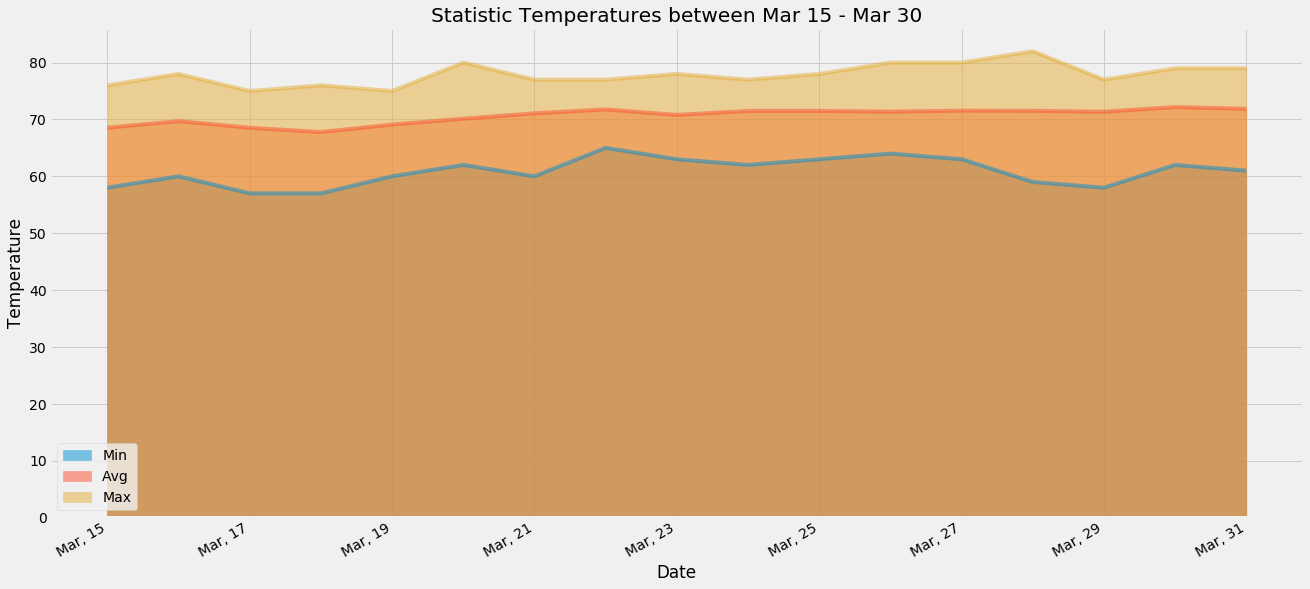

In [48]:
# Plot the daily normals as an area plot with `stacked=False`

# plt.rcParams['figure.figsize'] = (20,20)
normals_df.plot.area(figsize=(20,10),stacked=False, x_compat = True)

#-- gcf() is get current figure : Using to slanted date in x-axis
# plt.gcf().autofmt_xdate()

#-- change date format to be Mmm, dd,YYYY
date_format = mpl_dates.DateFormatter('%b, %d')
#-- .gca() is get current axis
plt.gca().xaxis.set_major_formatter(date_format)
#-- gcf() is get current figure
# plt.gcf().autofmt_xdate()

plt.title('Statistic Temperatures between Mar 15 - Mar 30')
plt.xlabel("Date")
plt.ylabel("Temperature")